In [1]:
using MAT
using LinearAlgebra

import PyPlot; plt = PyPlot;

**Load data**

In [98]:
num_rows = 32
sparsity = 0.5
KL = "_K20_L15_B"
folder = "/home/asd/data/heart/results/"
filename = folder * "train_" * string(num_rows) * KL * string(sparsity) * "_results.mat"
breakfilename = folder * "breaks_" * string(num_rows) * ".mat"
labelfilename = folder * "order.mat"
datafilename = folder * "train_" * string(num_rows) * ".mat"

md_data = matread(datafilename)
md_train = matread(filename)
md_test = matread(string(filename[1:end-4], "_usereval.mat"))
md_breaks = matread(breakfilename)
md_labels = matread(labelfilename);

md_train["loss_hist"]

21-element Array{Float64,1}:
 0.9754096706610791  
 0.3258862891834057  
 0.15605761944389415 
 0.09135089020637074 
 0.06855157816587056 
 0.05772903303701199 
 0.05083223793711657 
 0.045320524309214794
 0.041546251148105236
 0.038376989498585846
 0.03568729855772616 
 0.03294689280982488 
 0.031284826314929154
 0.030426565137880838
 0.02864769966087664 
 0.027781500855696483
 0.027215219063966956
 0.025678303269271962
 0.024890140295093666
 0.024540341422640298
 0.02434801650395916 

In [62]:
traindata = md_data["signal"]
trainmap = md_train["H"]
trainbreaks = md_breaks["train_breaks"]
trainlabels = md_labels["trainorder"]

# Split labels into 
trainlabels = split.(trainlabels, "_")
grouplabels = [label[1] for label in trainlabels]
numlabels = [parse(Int64, label[2]) for label in trainlabels];

In [63]:
padsize = 100

# Associate each training user with their assigned feature map
features = Dict()
segments = Dict()
push!(trainbreaks, size(trainmap, 2)+padsize)
for i = 1:length(trainlabels)
    group = grouplabels[i]
    num = numlabels[i]
        
    start = trainbreaks[i]
    last = trainbreaks[i+1]-padsize
    features[(group, num)] = trainmap[:, start:last]
    segments[(group, num)] = traindata[:, start:last]
end

**Zero-order classifier**

Integrate and to training data.

In [64]:
# Set up weights for each group based on training data

groups = unique(grouplabels)
num_groups = length(unique(grouplabels))
num_motifs = size(trainmap, 1)

archetypes = Dict()
for grp in groups
    archetypes[grp] = zeros(num_motifs)
end

for (grp, num) in keys(features)
    H = features[(grp, num)]
    weight = sum(H, dims=2)
    weight = weight / norm(weight)
    
    archetypes[grp] += weight
end

for grp in groups
    archetypes[grp] /= norm(archetypes[grp])
end

archmat = zeros(num_groups, num_motifs)
for (i, grp) in enumerate(groups)
    archmat[i, :] = archetypes[grp]
end

In [69]:
# Check train
for (k, v) in md_test
    weight = reshape(sum(v, dims=2), num_motifs)
    weight /= norm(weight)
    
    estk = groups[argmax(archmat * weight)]
    println("Eval: ", k[1:end-2] == estk)
    println(k[1:end-2], " - ", estk)
    println()
end

Eval: false
AFIB - NSR

Eval: false
LBBB - NSR

Eval: false
NSR - APB

Eval: false
AFL - LBBB

Eval: true
APB - APB

Eval: false
RBBB - Bigeminy

Eval: true
Bigeminy - Bigeminy

Eval: false
Trigeminy - NSR



Well that was bad...

**Concatenate data within each group**

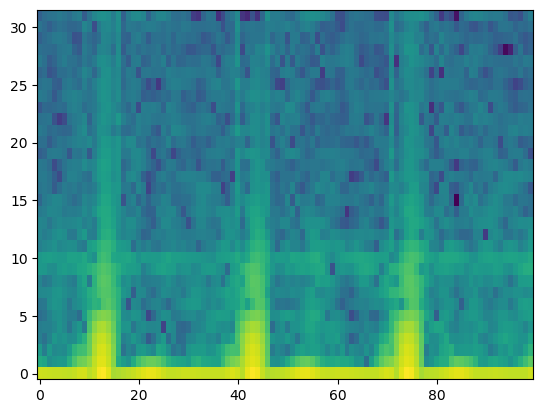

PyObject <matplotlib.image.AxesImage object at 0x7fa276549a90>

In [76]:
for grp in groups
    

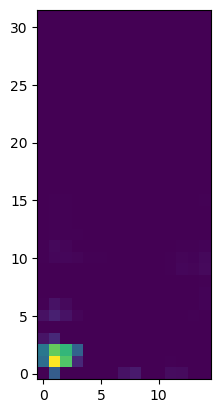

PyObject <matplotlib.image.AxesImage object at 0x7fa275ce9bd0>

In [97]:
plt.imshow(md_train["W"][:, :, 20]', origin="auto")